**Import modules and .txt files as dataframe**

In [391]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [392]:
# Import nmdb data
colnames = ['datetime', 'OULU', 'THUL', 'SOPO']
stations = colnames[1:]
filenames = ['data_2min_fd2015.txt', 'data_2min_fd2021.txt',
             'data_2min_2022_1.txt', 'data_2min_2022_2.txt', 'data_2min_2022_3.txt',
             'data_2min_2023_1.txt', 'data_2min_2023_2.txt', 'data_2min_2023_3.txt',
             'data_2min_2024_1.txt', 'data_2min_2024_2.txt', 'data_2min_2024_3.txt']
dataframes = []

for filename in filenames:
    df = pd.read_csv(filename, sep=';', comment='#', names=colnames) # Import
    df = df.drop(index=0).reset_index(drop=True) # Remove first row
    df.datetime = pd.to_datetime(df.datetime, format="%Y-%m-%d %H:%M:%S") # Convert to datetime
    for s in stations: # Convert invalid data to nan
        df[s] = pd.to_numeric(df[s], errors='coerce')
    
    dataframes.append(df) # Add to df list

# Extract as individual dataframes
fd15, fd21, data22_1, data22_2, data22_3, data23_1, data23_2, data23_3, data24_1, data24_2, data24_3 = dataframes

# Merge data22, data23, data24
data22 = pd.concat([data22_1, data22_2, data22_3], ignore_index=True)
data23 = pd.concat([data23_1, data23_2, data23_3], ignore_index=True)
data24 = pd.concat([data24_1, data24_2, data24_3], ignore_index=True)

# Reset dataframes
dataframes = [fd15, fd21, data22, data23, data24]

data22

,datetime,OULU,THUL,SOPO
0,2022-01-01 00:00:00,113.841,128.690,323.080
1,2022-01-01 00:02:00,112.471,127.080,322.520
2,2022-01-01 00:04:00,109.361,129.670,320.735
3,2022-01-01 00:06:00,111.478,127.745,323.885
4,2022-01-01 00:08:00,109.945,132.790,321.430
...,...,...,...,...
250555,2022-12-14 23:50:00,106.889,121.960,296.755
250556,2022-12-14 23:52:00,104.976,122.730,301.595
250557,2022-12-14 23:54:00,102.901,124.220,299.240
250558,2022-12-14 23:56:00,106.238,122.120,296.765


In [483]:
def draw_baselines(ax, offset, interval):
    lw = 0.5
    ax.axhline(y=offset, linestyle="--", linewidth=lw, color='black')
    ax.axhline(y=offset - interval, linestyle="--", linewidth=lw, color='black')
    ax.axhline(y=offset + interval, linestyle="--", linewidth=lw, color='black')

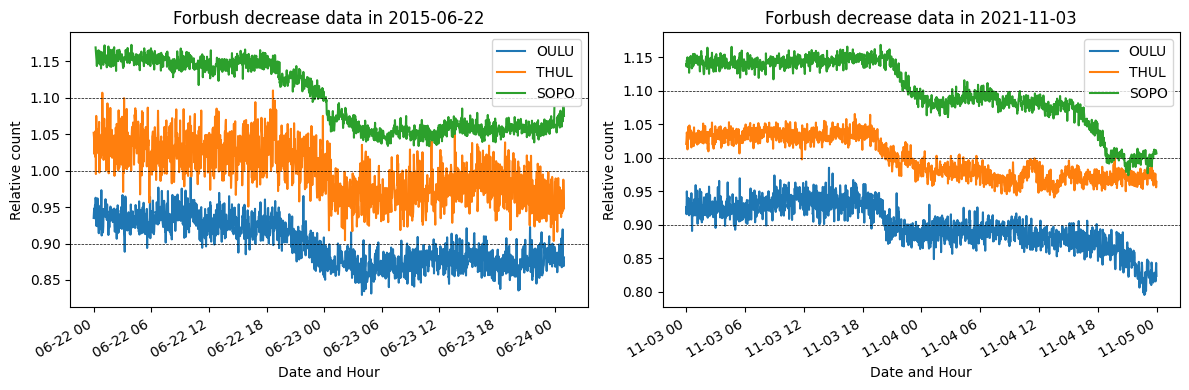

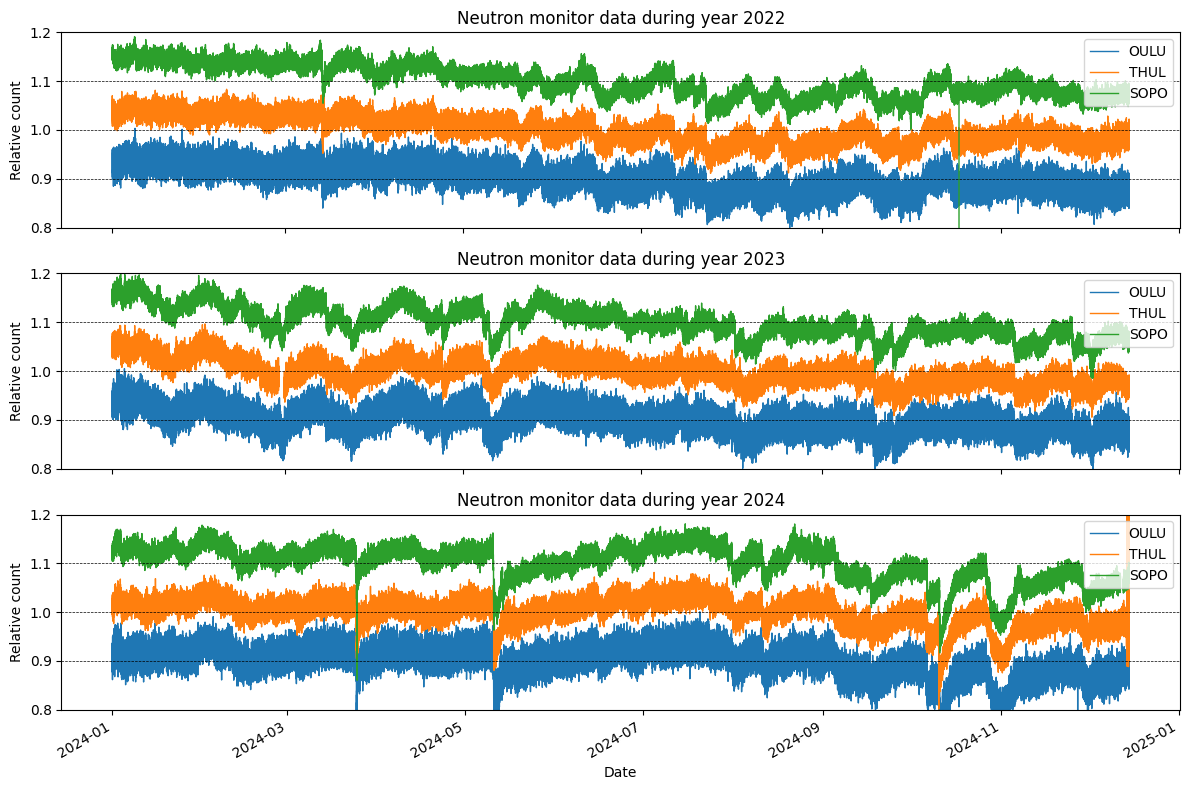

In [484]:
# Plot Forbush decrease data
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax1, ax2 = ax

for i, s in enumerate(stations):
    shift = (i-1) * 0.1
    ax1.plot(fd15.datetime, fd15[s] / fd15[s].mean() + shift, label=s)
    ax2.plot(fd21.datetime, fd21[s] / fd21[s].mean() + shift, label=s)

ax1.set_title('Forbush decrease data in 2015-06-22')
ax2.set_title('Forbush decrease data in 2021-11-03')

for a in ax:
    a.set_ylabel('Relative count')
    a.set_xlabel('Date and Hour')
    a.legend(loc='upper right')
    draw_baselines(a, 1, 0.1)
    
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

# Plot year-long neutron monitor data
fig, ax = plt.subplots(3, 1, figsize=(12, 8))
ax1, ax2, ax3 = ax

for i, s in enumerate(stations):
    shift = (i-1) * 0.1
    ax1.plot(data22.datetime, data22[s] / data22[s].mean() + shift, label=s, linewidth=1)
    ax2.plot(data23.datetime, data23[s] / data23[s].mean() + shift, label=s, linewidth=1)
    ax3.plot(data24.datetime, data24[s] / data24[s].mean() + shift, label=s, linewidth=1)

ax1.set_title('Neutron monitor data during year 2022')
ax2.set_title('Neutron monitor data during year 2023')
ax3.set_title('Neutron monitor data during year 2024')

for a in ax:
    a.set_ylabel('Relative count')
    a.set_xlabel('Date')
    a.legend(loc='upper right')
    a.set_ylim(0.8, 1.2)
    draw_baselines(a, 1, 0.1)
    
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

**Signal processing before applying CCF!**

Noise and long-term signal movement removal with running mean calculations

In [450]:
def from_rolling_mean(signal): # from 6-hour rolling mean
    minutes = 60*6
    window = int(minutes/2)
    rolling = signal.rolling(window=window, min_periods=1).mean()
    signal_frm = signal - rolling
    
    return signal_frm

In [451]:
for df in dataframes:
    for s in stations:
        df[f'{s}_frm'] = from_rolling_mean(df[s])

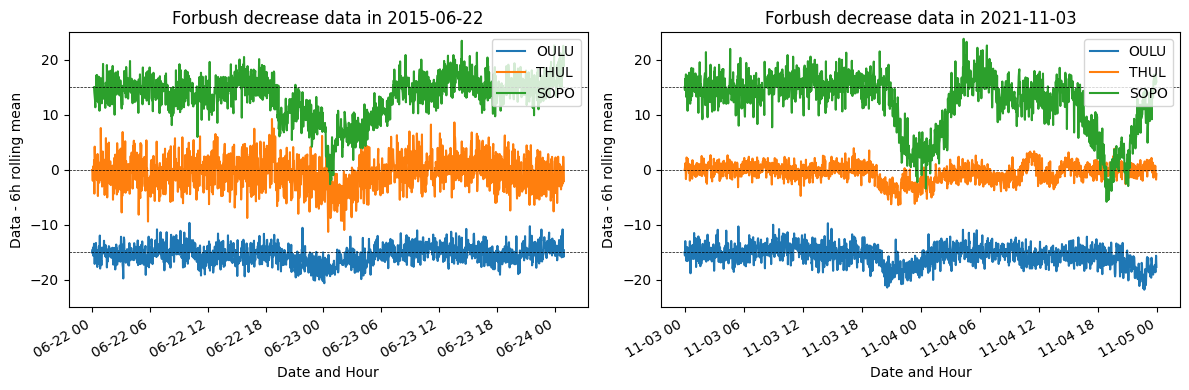

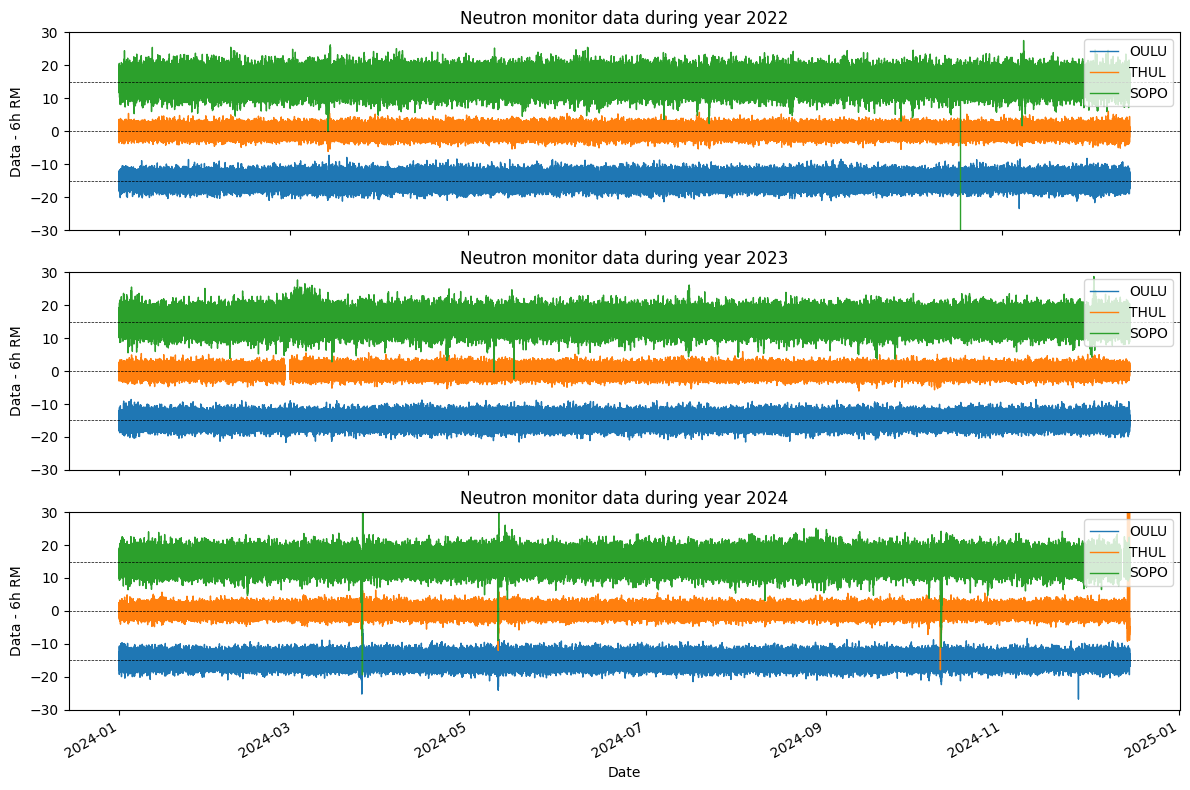

In [501]:
# Plot Forbush decrease data (Rolling mean)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax1, ax2 = ax

for i, s in enumerate(stations):
    shift = (i-1) * 15
    colname = f'{s}_frm'
    ax1.plot(fd15.datetime, fd15[colname] + shift, label=s)
    ax2.plot(fd21.datetime, fd21[colname] + shift, label=s)

ax1.set_title('Forbush decrease data in 2015-06-22')
ax2.set_title('Forbush decrease data in 2021-11-03')

for a in ax:
    a.set_ylabel('Data - 6h rolling mean')
    a.set_xlabel('Date and Hour')
    a.legend(loc='upper right')
    draw_baselines(a, 0, 15)
    a.set_ylim(-25, 25)
    
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

# Plot year-long neutron monitor data (from running mean)
fig, ax = plt.subplots(3, 1, figsize=(12, 8))
ax1, ax2, ax3 = ax

for i, s in enumerate(stations):
    shift = (i-1) * 15
    colname = f'{s}_frm'
    ax1.plot(data22.datetime, data22[colname] + shift, label=s, linewidth=1)
    ax2.plot(data23.datetime, data23[colname] + shift, label=s, linewidth=1)
    ax3.plot(data24.datetime, data24[colname] + shift, label=s, linewidth=1)

ax1.set_title('Neutron monitor data during year 2022')
ax2.set_title('Neutron monitor data during year 2023')
ax3.set_title('Neutron monitor data during year 2024')

for a in ax:
    a.set_ylabel('Data - 6h RM')
    a.set_xlabel('Date')
    a.legend(loc='upper right')
    draw_baselines(a, 0, 15)
    a.set_ylim(-30, 30)
    
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

**Discrete-time cross correlation of NM signal and historical FD signal**

In [495]:
# Code prototyping, will replace with handwritten code
def CCF(signal, fd):
    # Makes nan to zero to avoid null results
    signal_clean = np.nan_to_num(signal, nan=0.0)
    fd_clean = np.nan_to_num(fd, nan=0.0)

    CCF = scipy.signal.correlate(signal_clean, fd_clean, mode='full')
    CCF_max = np.nanmax(CCF)
    
    lags = np.arange(-len(fd)+1, len(signal))
    return lags, CCF/CCF_max

**Compute cross-correlation and plot**

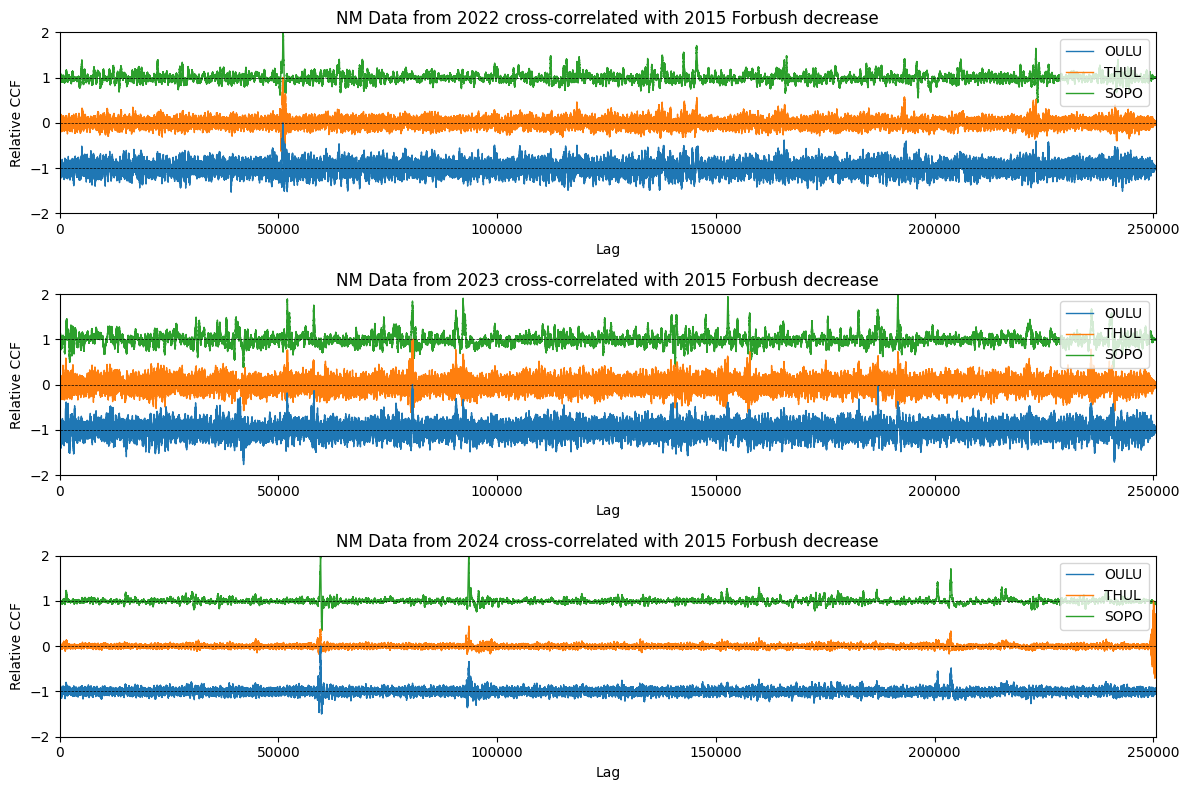

In [502]:
# Plot year-long CCF
fig, ax = plt.subplots(3, 1, figsize=(12, 8))
ax1, ax2, ax3 = ax

for i, s in enumerate(stations):
    shift = (i-1) * 1
    station_colname = f'{s}_frm'
    lag22, ccf22 = CCF(data22[station_colname], fd15[station_colname])
    lag23, ccf23 = CCF(data23[station_colname], fd15[station_colname])
    lag24, ccf24 = CCF(data24[station_colname], fd15[station_colname])
    
    ax1.plot(lag22, ccf22 + shift, label=s, linewidth=1, zorder=-shift)
    ax2.plot(lag23, ccf23 + shift, label=s, linewidth=1, zorder=-shift)
    ax3.plot(lag24, ccf24 + shift, label=s, linewidth=1, zorder=-shift)

ax1.set_title('NM Data from 2022 cross-correlated with 2015 Forbush decrease')
ax2.set_title('NM Data from 2023 cross-correlated with 2015 Forbush decrease')
ax3.set_title('NM Data from 2024 cross-correlated with 2015 Forbush decrease')

for a in ax:
    a.set_ylabel('Relative CCF')
    a.set_xlabel('Lag')
    a.legend(loc='upper right')
    a.set_xlim(0, lag22.max())
    a.set_ylim(-2, 2)
    draw_baselines(a, 0, 1)

plt.tight_layout()
plt.show()